<a href="https://colab.research.google.com/github/sergioGarcia91/ML_and_EDA/blob/main/01d_Sismos_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means - Dataset: Sismos_V01.csv


> *Ser tan rápidos como el más lento, \
> y ser tan lentos como el más rápido.*

**Autor:** Sergio Andrés García Arias  
**Versión 01:** Diciembre 2023

# Introducción

En este Notebook utilizaremos el algoritmo de agrupamiento `K-Means`. Este algoritmo se emplea para agrupar un conjunto de datos en `k` cluster distintos, este proceso se lleva a cabo de manera iterativa.

> **Observación:** Al igual que con el algoritmo DBSCAN, nos enfocaremos únicamente en el componente espacial de los sismos.

## ¿Cómo funciona?

1. **Inicialización de Centroides:** Comienza seleccionando aleatoriamente `K` puntos como centroides iniciales.

2. **Asignación de Puntos a Clusters:** Cada punto de datos se asigna al cluster cuyo centroide es más cercano.

3. **Actualización de Centroides:** Los centroides de los clusters se recalculan tomando la media de todos los puntos asignados a ese cluster. Esto mueve el centroide hacia el "centro" del cluster.

4. **Repetición:** Los pasos 2 y 3 se repiten iterativamente hasta que no haya cambios significativos en la asignación de puntos a clusters o se alcance un número predeterminado de iteraciones.

5. **Resultado Final:** Una vez que el algoritmo ha convergido, se obtiene un conjunto de clusters con centroides representativos.


<figure>
<center><img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*rw8IUza1dbffBhiA4i0GNQ.png' width=500px \>

El algoritmo K-Means encuentra observaciones que comparten características importantes y las clasifica juntas en clusters. Una solución de agrupamiento exitosa es aquella que encuentra clusters de manera que las observaciones dentro de cada cluster sean más similares entre sí que con los otros clusters.

*Fuente: [Alan Jeffares, (2019)](https://towardsdatascience.com/k-means-a-complete-introduction-1702af9cd8c)*
</figure>


# Inicio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import time


from sklearn.cluster import KMeans # Para agrupar los sismos

# Cargar CSV

In [2]:
url ='https://github.com/sergioGarcia91/ML_and_EDA/raw/main/Datasets/Sismos_V01.csv'
df = pd.read_csv(url, sep=';', decimal=',')
df = df.dropna()
df = df.drop_duplicates(subset=['FECHA - HORA UTC', 'LATITUD (°)', 'LONGITUD (°)'])
df = df.reset_index(drop=True)
# Trabajaremos solo en kilometros
df['X (km)'] = df['X_3116'] / 1000
df['Y (km)'] = df['Y_3116'] / 1000
df.head()

FECHA - HORA UTC TIPO MAGNITUD  LATITUD (°)  LONGITUD (°)     X_3116  \
0   15/09/2019 2:20         MLr_3        5.711       -73.881  1021767.3   
1   8/08/2020 19:17         MLr_3        5.713       -73.861  1023982.6   
2  26/02/2020 22:32         MLr_3        5.716       -73.867  1023317.9   
3   14/09/2018 4:07           MLr        5.717       -73.817  1028856.4   
4   19/03/2018 6:44           MLr        5.719       -73.864  1023650.1   

        Y_3116  PROF. (Km)  MAGNITUD  FASES  RMS (Seg)  GAP (°)  \
0  1123281.898      100.05       1.6    9.0        0.3    140.0   
1  1123503.864      123.00       1.5   12.0        0.8     96.0   
2  1123835.376      108.85       1.5   18.0        0.4     96.0   
3  1123948.230      107.61       1.2   12.0        0.3     99.0   
4  1124167.257      112.70       1.5   12.0        0.4    130.0   

   ERROR LATITUD (Km)  ERROR LONGITUD (Km)  ERROR PROFUNDIDAD (Km)  \
0               2.404                2.404                     3.8   
1               4.031                4.031                     7.1   
2               1.131                1.131                     2.3   
3               1.344                1.344                     2.4   
4               1.768                1.768                     3.5   

  DEPARTAMENTO MUNICIPIO  ESTADO     X (km)       Y (km)  
0    Santander  Albania   manual  1021.7673  1123.281898  
1    Santander  Albania   manual  1023.9826  1123.503864  
2    Santander  Albania   manual  1023.3179  1123.835376  
3    Santander  Albania   manual  1028.8564  1123.948230  
4    Santander  Albania   manual  1023.6501  1124.167257

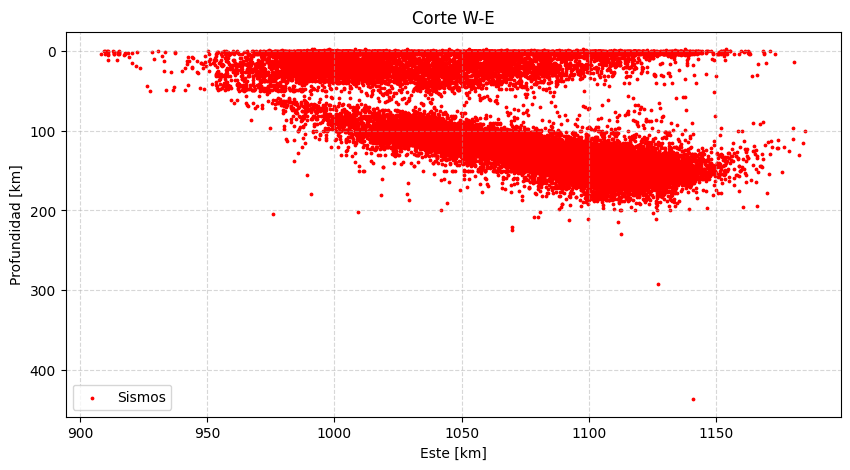

In [3]:
plt.figure(figsize=(10,5))

plt.scatter(df['X (km)'],
            df['PROF. (Km)'],
            c='r',
            s=3,
            label='Sismos')
plt.gca().invert_yaxis()

plt.grid(ls='--', alpha=0.5)
plt.legend()
plt.xlabel('Este [km]')
plt.ylabel('Profundidad [km]')
plt.title('Corte W-E')

plt.show()

# K-Means

Para llevar a cabo la agrupación o generación de clusters en el catálogo de eventos sísmicos, utilizaremos la clase [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) implementada en la biblioteca `Scikit-Learn`.

Para simplificar el proceso y hacerlo más accesible, nos centraremos en la configuración de un parámetro crucial:

- `n_clusters`: la cantidad de clusters o grupos que deseamos crear.
- `random_state`: un parámetro que asegura la reproducibilidad del modelo, garantizando que los resultados sean consistentes entre diferentes ejecuciones.


In [4]:
# Crearemos un nuevo DataFrame
df_Kmeans = df[['X (km)', 'Y (km)', 'PROF. (Km)']]
df_Kmeans.head()

X (km)       Y (km)  PROF. (Km)
0  1021.7673  1123.281898      100.05
1  1023.9826  1123.503864      123.00
2  1023.3179  1123.835376      108.85
3  1028.8564  1123.948230      107.61
4  1023.6501  1124.167257      112.70

In [5]:
# Por lo visto en el EDA se puede dividir en 2 grupos los sismos
# menores a 50 km y
# mayores a 50 km
# por lo que solo vamos a considerar un k=2
modelo_KMeans = KMeans(n_clusters=2, random_state=0) # Crear el modelo
modelo_KMeans.fit(df_Kmeans) # Entrenar

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

array([[1100.49871564, 1241.08706407,  141.65444361],
       [1030.7839258 , 1294.07588656,   22.56072232]])

In [6]:
np.unique(modelo_KMeans.labels_) # Ver las etiquetas unicas

array([0, 1], dtype=int32)

In [7]:
modelo_KMeans.cluster_centers_ # centroides

array([[1100.49871564, 1241.08706407,  141.65444361],
       [1030.7839258 , 1294.07588656,   22.56072232]])

In [8]:
# Graficar los clusters generados
fig = go.Figure(data=[go.Scatter3d(
     x=df_Kmeans['X (km)'],
     y=df_Kmeans['Y (km)'],
     z=-1*df_Kmeans[ 'PROF. (Km)'],
     mode='markers',
     marker=dict(
          size=2,
          color=modelo_KMeans.labels_,
          opacity=0.8)
     )])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Aunque en el EDA se llegó a una posible conclusión de que era factible diferenciar dos grupos de eventos sísmicos en función de su profundidad:

1. Menores a 50 km
2. Mayores a 50 km

Al utilizar un valor de `k=2` en el algoritmo de `k-means`, si logra dividir en dos clusters, pero no de la manera óptima o esperada. Este resultado no implica que el algoritmo carezca de utilidad; sin embargo, es posible que, para este caso particular, no sea la elección más adecuada para la tarea de clusterización. ¿O será que existen más clusters?

---
De manera similar a la evaluación realizada con el algoritmo `DBSCAN`, surgen interrogantes adicionales que deben considerarse para evaluar la implementación del algoritmo. Algunas de estas consideraciones podrían incluir:

- ¿Afecta la distribución de los Datos?
- ¿Existe algún tipo de solapamiento que pueda afectar la capacidad de K-means para distinguir los grupos de manera efectiva?
- ¿Será requerido la normalización de Datos?
- ¿Incluir más variables para la clasificación?
- ¿Utilizar otros algoritmos?
- ¿Variar el número de clústeres?
- ¿Evaluación de la Calidad de los clústeres con alguna métrica? *En un próximo Notebook*
- ¿Se debe incluir alguna consideración geofísica o geológica?

Abordar estas preguntas adicionales puede ayudar a comprender mejor el rendimiento de K-means en este contexto específico y a determinar si otros métodos serían más apropiados para la tarea de clusterización.

# Multiples Modelos

In [9]:
# Generar 3 modelos con k diferente
numero_K = np.array([2, 3, 5]) # Valores de k
dic_centroides = {} # Para guardar los centroides

for k_clusters in numero_K:
  modelo_KMeans = KMeans(n_clusters=k_clusters, random_state=0)
  modelo_KMeans.fit(df_Kmeans)

  df_Kmeans[f'k{k_clusters}'] = modelo_KMeans.labels_
  dic_centroides[f'k{k_clusters}'] = modelo_KMeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-9-22c4d5de22f7>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-9-22c4d5de22f7>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [10]:
df_Kmeans.head()

X (km)       Y (km)  PROF. (Km)  k2  k3  k5
0  1021.7673  1123.281898      100.05   0   2   1
1  1023.9826  1123.503864      123.00   0   2   1
2  1023.3179  1123.835376      108.85   0   2   1
3  1028.8564  1123.948230      107.61   0   2   1
4  1023.6501  1124.167257      112.70   0   2   1

In [11]:
dic_centroides['k2']# solo tomar las primeras 3 columnas
# por revisar las otras ... el error ?

array([[1100.49871564, 1241.08706407,  141.65444361],
       [1030.7839258 , 1294.07588656,   22.56072232]])

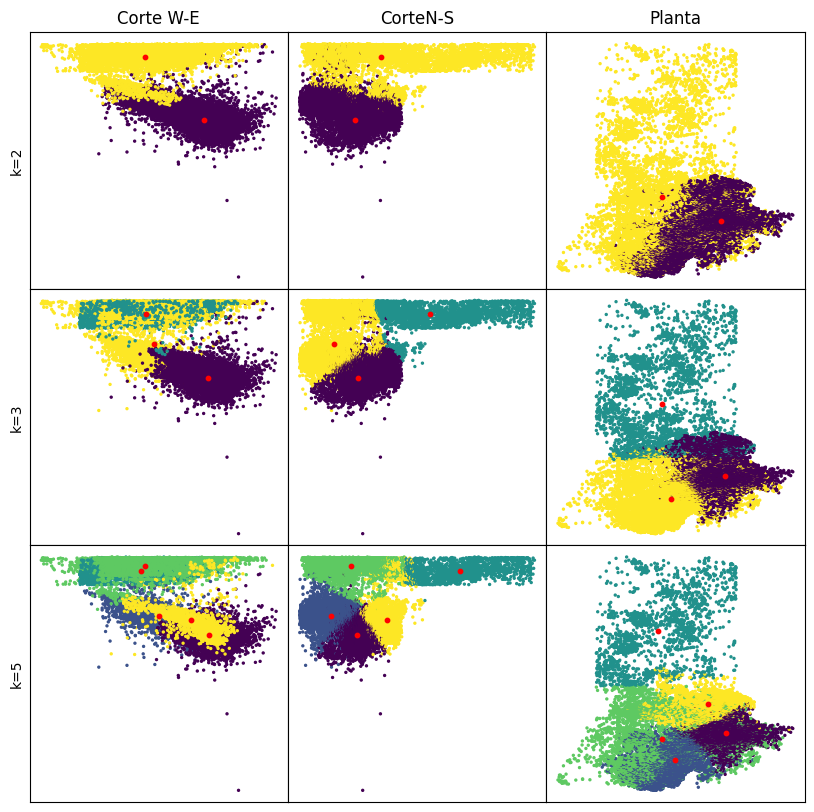

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0)

for plot in range(len(numero_K)):
  centroides = dic_centroides['k{}'.format(numero_K[plot])][:,0:3]

  # X vs Prof
  ax[plot,0].scatter(df_Kmeans['X (km)'],
            -1*df_Kmeans['PROF. (Km)'],
            c=df_Kmeans['k{}'.format(numero_K[plot])],
            s=2)
  # Centroides
  ax[plot,0].scatter(centroides[:,0],
            -1*centroides[:,2],
            c='r',
            s=10)
  # Hide X and Y axes label marks
  ax[plot,0].xaxis.set_tick_params(labelbottom=False)
  ax[plot,0].yaxis.set_tick_params(labelleft=False)
  # Hide X and Y axes tick marks
  ax[plot,0].set_xticks([])
  ax[plot,0].set_yticks([])


  # Y vs Prof
  ax[plot,1].scatter(df_Kmeans['Y (km)'],
            -1*df_Kmeans['PROF. (Km)'],
            c=df_Kmeans['k{}'.format(numero_K[plot])],
            s=2)
  # Centroides
  ax[plot,1].scatter(centroides[:,1],
            -1*centroides[:,2],
            c='r',
            s=10)
  # Hide X and Y axes label marks
  ax[plot,1].xaxis.set_tick_params(labelbottom=False)
  ax[plot,1].yaxis.set_tick_params(labelleft=False)
  # Hide X and Y axes tick marks
  ax[plot,1].set_xticks([])
  ax[plot,1].set_yticks([])


  # X vs Y
  ax[plot,2].scatter(df_Kmeans['X (km)'],
            df_Kmeans['Y (km)'],
            c=df_Kmeans['k{}'.format(numero_K[plot])],
            s=2)
  # Centroides
  ax[plot,2].scatter(centroides[:,0],
            centroides[:,1],
            c='r',
            s=10)
  # Hide X and Y axes label marks
  ax[plot,2].xaxis.set_tick_params(labelbottom=False)
  ax[plot,2].yaxis.set_tick_params(labelleft=False)
  # Hide X and Y axes tick marks
  ax[plot,2].set_xticks([])
  ax[plot,2].set_yticks([])

  if plot==0:
    ax[plot,0].set_title('Corte W-E')
    ax[plot,1].set_title('CorteN-S')
    ax[plot,2].set_title('Planta')

    ax[plot,0].set_ylabel('k={}'.format(numero_K[plot]))

  if plot==1:
    ax[plot,0].set_ylabel('k={}'.format(numero_K[plot]))

  if plot==2:
    ax[plot,0].set_ylabel('k={}'.format(numero_K[plot]))

plt.show()

# Observaciones

Aunque K-Means es un algoritmo de agrupamiento popular y eficiente, tiene algunas desventajas y limitaciones que es importante tener en cuenta:

1. **Sensibilidad a los Centroides Iniciales:** K-means puede converger a diferentes soluciones dependiendo de la elección inicial de los centroides. Iniciar con centroides subóptimos puede conducir a resultados no óptimos.

2. **Número de Clústeres (`K`) debe ser Conocido:** El usuario debe especificar el número de clústeres antes de ejecutar el algoritmo. En la práctica, a veces no conocemos el número óptimo de clústeres de antemano, lo que puede requerir técnicas adicionales para determinar el valor correcto.

3. **Sensibilidad a Outliers:** K-means es sensible a los valores atípicos (outliers), ya que la media se ve afectada por valores extremos. Los outliers pueden afectar negativamente la calidad de los clusters.

4. **Forma de Cluster Esférica:** K-means asume que los clusters son esféricos (al trabajar la distancia euclidiana) y de tamaño similar. Si los clusters tienen formas más complejas (no esféricas) o tamaños variados, K-means puede producir resultados subóptimos.

5. **Impacto de la Escala:** La escala de las variables puede afectar los resultados. Variables con escalas muy diferentes pueden tener un impacto desproporcionado en la formación de clusters.

6. **No Adecuado para Datos no Lineales o No Convexos:** K-means funciona bien en clusters de forma convexa, pero puede tener dificultades con clusters de formas no convexas o datos no lineales.

7. **Requiere Datos Numéricos:** K-means opera con distancias euclidianas, lo que limita su aplicabilidad a datos numéricos. No es adecuado para datos categóricos o textuales sin algún tipo de preprocesamiento.

8. **Iterativo y Sensible al Punto de Inicio:** La convergencia de K-means es iterativa y depende del punto de inicio. Puede no converger a la solución óptima en todos los casos.



# Fin